# Анализ тарифов "Мегалайн"

## Описание проекта

Мы аналитики компании «Мегалайн» — федерального оператора сотовой связи. 

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Будем проводить анализ в несколько этапов.

1. [Изучим описание тарифов.](#describe)
2. [В нашем распоряжении будет несколько таблиц. Прочитаем их и сделаем обзор каждого столбца каждой таблицы.](#view)
3. [Предобработка данных в таблицах. Поиск пропусков, дубликатов, работа с аномалиями в данных, приведение типов данных.](#prepare)<br>
    3.1 [Таблица `users`](#users)<br>
    3.2 [Таблица `calls`](#calls)<br>
    3.3 [Таблица `messages`](#messages)<br>
    3.4 [Таблица `internet`](#internet)<br>
    3.5 [Таблица `tariffs`](#tariffs)<br>
4. [Подсчет показателей и выручки по каждому пользователю.](#count_income)
5. [Анализ данных.](#analis)
6. [Проверка гипотезы.](#hipotes)
7. [Выводы.](#resume)

## Описание тарифов <a name='describe'></a>

**Тариф «Смарт»**

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Обзор данных <a name="view"></a>

Импорт библиотек:

In [1]:
import pandas as pd        # импортируем библиотеку pandas
import seaborn as sps      # импортируем библиотеку seaborn
from scipy import stats as st # импортируем библиотеку для статистического анализа
from matplotlib import pyplot as plt # импортируем библиотеку для построения графиков
import plotly.express as px # импорт библиотеки для построение интерактивных графиков
import numpy as np # импортируем библиотеку numpy
from datetime import datetime # импортируем библиотеку для работы с типами datetime
import os

In [2]:
# читаем наши csv-файлы, помещая их содержимое в датафреймы с теми же именами
pth1 = '/datasets/users.csv'
pth2 = 'users.csv'

if os.path.exists(pth1): # если читаем из окружения Яндекса
    users = pd.read_csv(pth1)
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    calls = pd.read_csv('/datasets/calls.csv')
elif os.path.exists(pth2): # если читаем оттуда же, где лежат файлы
    users = pd.read_csv(pth2)
    tariffs = pd.read_csv('tariffs.csv')
    messages = pd.read_csv('messages.csv')
    internet = pd.read_csv('internet.csv')
    calls = pd.read_csv('calls.csv')
else:
    print('Не удается прочитать файлы')

pd.options.display.max_columns = 40 # столбцов много, поэтому устанавливаем отображение всех, с запасом

Посмотим на первые 5 строк каждого датафрейма и информацию по каждой таблице:

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [11]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [12]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


### Описание данных
Таблица `users` (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

Таблица `calls` (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Выводы:**

В нашем распоряжении 5 таблиц: информация о пользователях, их звонках, сообщениях, интернет-сессиях и тарифах.
Нарушений стилей заголовков не обнаружено.

Пропущенные значения есть только в таблице `users` в столбце `churn_date` - дата прекращения пользования тарифом. NaN означает, что тарифом еще пользовались на момент выгрузки данных. Формат дат в каждой таблице имеет тип `object`, нужно будет привести тип данных к `datetime`. 

Кроме того, в дальнейшем нужно будет округлить время разговоров до минут вверх. Для интернет-трафика приводить каждое отдельное значение не будем - нужно будет считать помесячно для каждого пользователя и только затем округлять до гигабайт в бо́льшую сторону.

## Предобработка данных <a name="prepare"></a>

### Таблица `users` <a name="users"></a>

Поскольку пропуски есть только в табилце `users` в столбце `churn_date` и эти пропуски обоснованы, оставим их как есть.

Приведем типы данных всех дат во всех таблицах к необходимым:

In [13]:

users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')


Проверим корректность приведения типов:

In [14]:
display(users['churn_date'].sample(3), users['churn_date'].dtype,
users['reg_date'].sample(), users['reg_date'].dtype,
calls['call_date'].sample(), calls['call_date'].dtype,
messages['message_date'].sample(), messages['message_date'].dtype,
internet['session_date'].sample(), internet['session_date'].dtype)

183   NaT
207   NaT
75    NaT
Name: churn_date, dtype: datetime64[ns]

dtype('<M8[ns]')

423   2018-01-23
Name: reg_date, dtype: datetime64[ns]

dtype('<M8[ns]')

59474   2018-07-28
Name: call_date, dtype: datetime64[ns]

dtype('<M8[ns]')

27547   2018-07-26
Name: message_date, dtype: datetime64[ns]

dtype('<M8[ns]')

122528   2018-07-01
Name: session_date, dtype: datetime64[ns]

dtype('<M8[ns]')

Посмотри на возможные аномалии в данных. Начнем с `users`:

In [15]:
users['user_id'].is_unique # проверяем, все ли user_id уникальны

True

In [16]:
users['tariff'].unique() # проверяем все тарифы, которые есть у пользователей

array(['ultra', 'smart'], dtype=object)

In [17]:
users['city'].unique() # посмотрим на уникальные города

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [18]:
users['age'].sort_values().unique() # посмотрим возможные аномалии в возрасте

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75], dtype=int64)

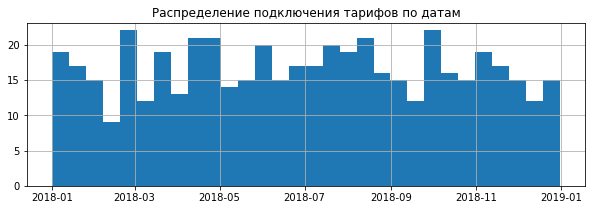

In [19]:
users['reg_date'].hist(bins=30, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение подключения тарифов по датам')
None

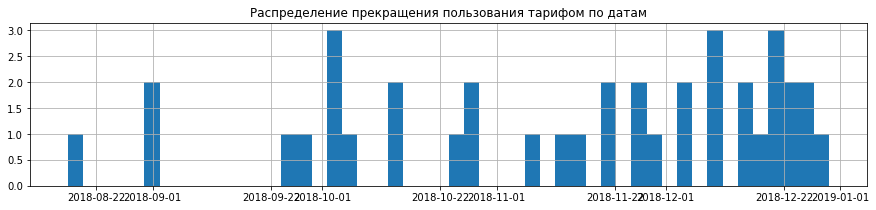

In [20]:
users['churn_date'].hist(bins=50, figsize=(15,3)) # строим гистограмму распределения
plt.title('Распределение прекращения пользования тарифом по датам')
None

In [21]:
# процент пользователей, которые на конец 2018 года продолжали пользоваться тарифом
users['churn_date'].isna().sum() / len(users) * 100 

92.4

Аномалий не выявлено. Интересно, что пользователи прекращали пользоваться тарифом, начиная с 22 августа 2018, до этого тарифом пользовались непрерывно. Возможно, это пригодится для дальнейшего анализа.

### Таблица `calls` <a name="calls"></a>

In [22]:
calls['id'].is_unique # проверяем, все ли вызовы уникальны

True

In [23]:
len(calls['user_id'].unique()) # считаем количество уникальных user_id

492

Из 500 пользователей вызовы делали только 492.

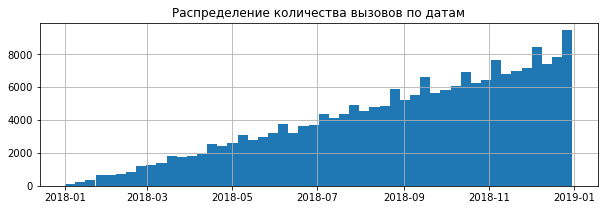

In [24]:
calls['call_date'].hist(bins=50, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение количества вызовов по датам')
None

Всё логично, люди примерно равномерно подключались в течение года, иногда отказываясь от тарифа (в 8% случаев).

То есть, с увеличением общего числа пользователей тарифов в течение года росло и количество вызовов. Тарифы явно успешны с точки зрения голосового трафика.

Посмотрим на длительность вызовов:

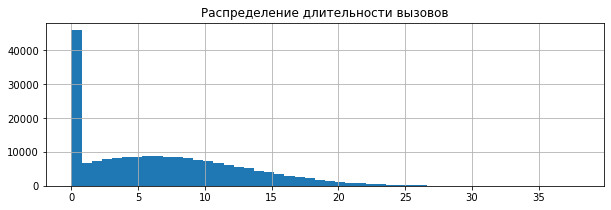

In [25]:
calls['duration'].hist(bins=50, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение длительности вызовов')
None

Есть очевидные выбросы около нуля. Это недозвоны до абонента, они не тарифицируются. Посмотрим, много ли таких вызовов:

In [26]:
print(calls.query('duration == 0')['duration'].count(),'что составляет',
      round(calls.query('duration == 0')['duration'].count() / len(calls) * 100,2),'%')


39613 что составляет 19.55 %


19% пропущенных вызовов - это очень много. Но их наличие не зависит от выбранного тарифа.
Посмотрим на распределение продолжительности вызовов, длительностью больше 0:

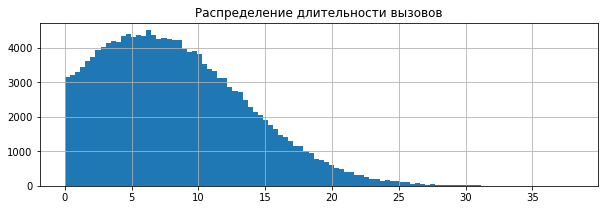

In [27]:
calls.query('duration > 0')['duration'].hist(bins=100, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение длительности вызовов')
None

Теперь похоже на нормальное распределение, смещенное влево (со скошенностью вправо). Это наверняка пригодится дальше.

### Таблица `messages`<a name="messages"></a>

In [28]:
messages['id'].is_unique # проверяем, все ли сообщения уникальны

True

In [29]:
len(messages['user_id'].unique()) # считаем уникальных пользователей

426

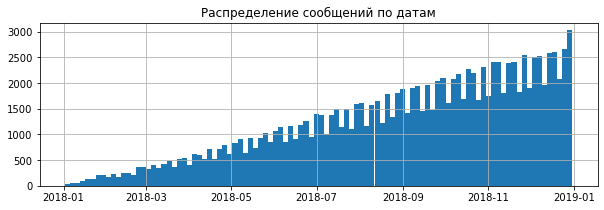

In [30]:
messages['message_date'].hist(bins=100, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение сообщений по датам')
None

Все сообщения в таблице `messages` уникальны.

Всего 426 пользователей из 500 пользовались сообщениями. 

Равномерный рост колчиества сообщений в течение года предсказуем в связи с увеличением суммарного числа пользователей тарифов.

### Таблица `internet`<a name="internet"></a>

In [31]:
internet['id'].is_unique # проверяем, все ли события уникальны

True

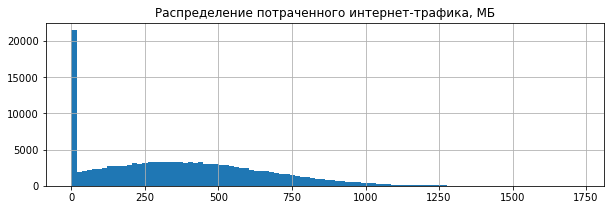

In [32]:
internet['mb_used'].hist(bins=100, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение потраченного интернет-трафика, МБ')
None

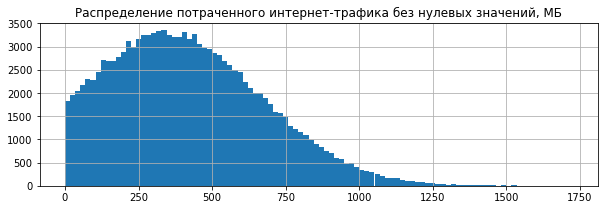

In [33]:
# строим гистограмму распределения без нулевых сессий
internet.query('mb_used > 0')['mb_used'].hist(bins=100, figsize=(10,3)) 
plt.title('Распределение потраченного интернет-трафика без нулевых значений, МБ')
None

Распределение соотествтует нормальному с положительной скошенностью.

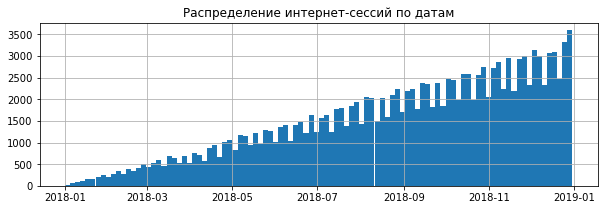

In [34]:
internet['session_date'].hist(bins=100, figsize=(10,3)) # строим гистограмму распределения
plt.title('Распределение интернет-сессий по датам')
None

По таблице `internet` можно сделать выводы:

* все события об интернет-сессиях уникальны;
* много веб-сессий с нулевым объемом трафика (это не является аномалией - нулевые сессии бывают на сетях передачи данных и могут относиться к техническим процессам, инициируемыми различными сетевыми службами пользовательского устройства или [сетевого оборудования](https://habr.com/ru/post/136844/#SNMP)). Оставим эти данные без изменения;
* распределение потребления трафика растет равномерно в течение года, также как голосовые вызовы и сообщения.

В таблице `tariffs`<a name="tariffs"></a> нет аномалий - она содержит всего две строки с описанием двух тарифов, которые нам необходимо сравнить между собой.

Поскольку ранее мы выявили, что все события в таблицах `calls`, `messages`, `internet` и пользователи таблицы `users` уникальные, то дубликатов в этих таблицах нет.

## Подсчет показателей и выручки по каждому пользователю<a name="count_income"></a>

Теперь подсчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

Для определения количества сделанных звонков по месяцам создадим в `calls` столбец `call_month` с месяцем и годом, который соответствует `call_date`

In [35]:
calls['call_month'] = calls['call_date'].dt.month # добавляем столбец с месяцем (если надо месяц с годом - использовать dt.to_period('M'))

В соответствии с условием задачи каждый звонок округляется отдельно до 1 минуты вверх. Округлим все необходимые значения в столбце `duration` таблицы `calls`:

In [36]:
calls['duration'] = calls['duration'].apply(np.ceil)

Теперь создадим отдельную таблицу `calls_pivot`, где будут храниться все необходимые значения вызовов по каждому пользователю:

In [37]:
# создаем сводную таблицу с подсчетом количества сделанных звонков и израсходованных минут (сумму)
calls_pivot = calls.pivot_table(
    index='user_id',
    columns='call_month',
    values='duration',
    aggfunc=['count', 'sum']
) 

calls_pivot.sample(5) # выводим 5 случайных строк полученной таблицы

count                                                               \
call_month    1   2     3     4     5     6     7     8      9      10     11   
user_id                                                                         
1431         NaN NaN  16.0  36.0  25.0  40.0  42.0  29.0   33.0   43.0   36.0   
1165         NaN NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   16.0   34.0   
1183         NaN NaN   NaN   NaN   NaN   NaN  40.0  69.0   81.0   63.0   55.0   
1001         NaN NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   59.0   
1319         NaN NaN   NaN   NaN   NaN   NaN   NaN  37.0  121.0  127.0  104.0   

                  sum                                                      \
call_month     12  1   2     3      4      5      6      7      8      9    
user_id                                                                     
1431         40.0 NaN NaN  89.0  266.0  163.0  318.0  299.0  196.0  214.0   
1165         37.0 NaN NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1183         82.0 NaN NaN   NaN    NaN    NaN    NaN  326.0  579.0  536.0   
1001         63.0 NaN NaN   NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1319        126.0 NaN NaN   NaN    NaN    NaN    NaN    NaN  305.0  729.0   

                                  
call_month      10     11     12  
user_id                           
1431         358.0  278.0  265.0  
1165         138.0  232.0  278.0  
1183         421.0  369.0  564.0  
1001           NaN  430.0  414.0  
1319        1005.0  706.0  868.0

Для подсчета количества отправленных сообщений по месяцам создадим в таблице `messages` столбец `message_month` с месяцем и годом события:

In [38]:
messages['message_month'] = messages['message_date'].dt.month # добавляем столбец с месяцем

Теперь создадим отдельную таблицу `messages_pivot`, где будут храниться все необходимые значения сообщений по каждому пользователю:

In [39]:
# создаем сводную таблицу с подсчетом количества сообщений,
messages_pivot = messages.pivot_table(
    index='user_id',
    columns='message_month',
    values='id',
    aggfunc='count'
) 

messages_pivot.sample(5) # выводим 5 случайных строк полученной таблицы

message_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,8.0
1141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,58.0
1287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,6.0,7.0
1286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,68.0


Подсчитаем объем израсходованного интренет-трафика по месяцам - таблица `internet`:

In [40]:
internet['session_month'] = internet['session_date'].dt.month # добавляем столбец с месяцем

Создадим сводную таблицу `internet_pivot`, в которой будет содержаться информация о ежемесячном объеме трафика каждым пользователем.
По условию задачи, для интернет-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. 
В одном ГБ содержится 1024 МБ данных. После подсчета ежемесятного объема трафика, разделим его на 1024, затем округлим вверх до ГБ и снова умножим на 1024, чтобы сохранить единицы измерения.

In [41]:
# создаем сводную таблицу с подсчетом объема трафика (сумму mb_used),
internet_pivot = internet.pivot_table(
    index='user_id',
    columns='session_month',
    values='mb_used',
    aggfunc='sum'
) 
    
# переводим МБ в ГБ, округляем ГБ вверх и обратно делим до МБ
internet_pivot = internet_pivot.apply(lambda x: np.ceil(x / 1024) * 1024) 
internet_pivot.sample(5) # выводим 5 случайных строк полученной таблицы

session_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1240,NaN,1024.0,28672.0,36864.0,44032.0,35840.0,41984.0,49152.0,31744.0,34816.0,32768.0,44032.0
1436,NaN,NaN,NaN,25600.0,23552.0,23552.0,21504.0,30720.0,23552.0,31744.0,16384.0,26624.0
1192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9216.0
1312,NaN,NaN,NaN,NaN,NaN,NaN,5120.0,20480.0,23552.0,23552.0,13312.0,22528.0
1157,NaN,4096.0,16384.0,27648.0,22528.0,25600.0,19456.0,18432.0,20480.0,27648.0,19456.0,28672.0


Теперь подсчитаем помесячную выручку с каждого пользователя. Для этого:
* вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
* остаток умнижим на значение из тарифного плана;
* прибавим абонентскую плату, соответствующую тарифному плану.

In [42]:
# присоединяем таблицу users для получения информации о тарифах каждого user_id
calls_pay = users.join(calls_pivot['sum'], on='user_id') 
# присоединяем таблицу с описанием тарифов
calls_pay = calls_pay.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left') 
# оставляем только те столбцы, которые нужны для подсчета
calls_pay = calls_pay[['user_id', 'tariff', 'minutes_included', 'rub_per_minute', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 

# напишем функцию, которая будет считать в таблице table по месяцам (range(1,13)) стоимость каждой минуты/сообщения/гигабайта для каждого пользователя

# в цикле по каждому пользователю, далее по каждому месяцу проверяем, если количество потраченных единиц больше бесплатного лимита, включенного в тариф,
# то количество потраченных сверх лимита (разность общей длительности за месяц и бесплатного лимита), умножаем результат на стоимость одной единицы сверх лимита
# иначе - ноль, то есть клиент не потратил бесплатный лимит и ничего платить не должен (все отицательные становятся нулями)
def pay_count(table, limit_value, rub_above_limit):
    for user in range(len(table)):
        for month in range(1,13):        
            if table.loc[user, month] > table.loc[user, limit_value]:
                table.loc[user, month] = (table.loc[user, month] - table.loc[user, limit_value]) * table.loc[user, rub_above_limit]
            else:
                table.loc[user, month] = 0

pay_count(calls_pay, 'minutes_included', 'rub_per_minute') # вызываем функцию подсчета выручки

calls_pay.sample(5) # выводим 5 случайных строчки

,user_id,tariff,minutes_included,rub_per_minute,1,2,3,4,5,6,7,8,9,10,11,12
385,1385,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,1381,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,1417,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,1413,smart,500,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,1013,ultra,3000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Сделаем тоже самое для сообщений - `messages`. Подсчитаем по каждому пользователю по своему тарифу выручку при использовании сообщений:

In [43]:
# присоединяем таблицу users для получения информации о тарифах каждого user_id
messages_pay = users.join(messages_pivot, on='user_id') 
# присоединяем таблицу с описанием тарифов
messages_pay = messages_pay.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left') 
# оставляем только те столбцы, которые нужны для подсчета.
messages_pay = messages_pay[['user_id', 'tariff', 'messages_included', 'rub_per_message', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 
# вызываем функцию подсчета выручки
pay_count(messages_pay, 'messages_included', 'rub_per_message') 

messages_pay.sample(5) # выводим 5 случайных строчки

,user_id,tariff,messages_included,rub_per_message,1,2,3,4,5,6,7,8,9,10,11,12
102,1102,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1027,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,1194,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
44,1044,smart,50,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,1404,smart,50,3,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,27.0,27.0,42.0


Перейдем к интернет-трафику - `internet`. Подсчитаем выручку по каждому пользователю с учетом его тарифа при использовании мобильного интернета:


In [44]:
# присоединяем таблицу users для получения информации о тарифах каждого user_id
internet_pay = users.join(internet_pivot, on='user_id') 
# присоединяем таблицу с описанием тарифов
internet_pay = internet_pay.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left') 
# оставляем только те столбцы, которые нужны для подсчета.
internet_pay = internet_pay[['user_id', 'tariff', 'mb_per_month_included', 'rub_per_gb', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]] 
internet_pay['rub_per_mb'] = internet_pay['rub_per_gb'] / 1024
# вызываем функцию подсчета выручки
pay_count(internet_pay, 'mb_per_month_included', 'rub_per_mb') 

internet_pay.sample(5) # выводим 5 случайных строчки

,user_id,tariff,mb_per_month_included,rub_per_gb,1,2,3,4,5,6,7,8,9,10,11,12,rub_per_mb
384,1384,smart,15360,200,0.0,0.0,0.0,0.0,1600.0,1400.0,600.0,600.0,1400.0,2200.0,600.0,1000.0,0.195312
284,1284,smart,15360,200,0.0,0.0,0.0,0.0,1000.0,400.0,0.0,0.0,0.0,1400.0,1000.0,200.0,0.195312
255,1255,ultra,30720,150,0.0,0.0,150.0,1050.0,1800.0,1050.0,2250.0,1650.0,0.0,0.0,0.0,0.0,0.146484
184,1184,smart,15360,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.195312
266,1266,smart,15360,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,0.0,1400.0,200.0,0.0,0.195312


Теперь подсчитаем общую выручку по каждому пользователю с учетом тарифа - просуммируем все значения трех таблиц `calls_pay`, `messages_pay` и `internet_pay`, в конце прибавим абонентскую плату за пользование тарифом:

In [45]:
# создаем сводную таблицу total_pay, которя содержит user_id, название тарифа
total_income = calls_pay[['user_id', 'tariff']]
# присоединяем описание тарифа
total_income = total_income.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')
# берем в итог только  user_id, название тарифа и абонетскую плату за месяц
total_income = total_income[['user_id', 'tariff', 'rub_monthly_fee']]

# для каждого месяца считаем общую сумму по каждому виду услуги, прибавляя абонентскую плату за месяц
for month in range(1, 13):
    total_income[month] = calls_pay[month] + messages_pay[month] + internet_pay[month] + total_income['rub_monthly_fee']
    
    total_income[month] = total_income[month].astype(int) # сразу прводим к типу int, чтобы не плодить доп. цикл

#выводим 10 случайных строк
total_income.sample(10)

,user_id,tariff,rub_monthly_fee,1,2,3,4,5,6,7,8,9,10,11,12
422,1422,smart,550,550,550,550,550,550,550,550,550,550,550,550,550
421,1421,smart,550,550,550,2380,550,1550,756,1789,1550,2186,1959,2550,550
406,1406,smart,550,550,550,550,550,550,550,550,550,550,550,550,550
129,1129,smart,550,550,550,550,550,550,550,550,550,550,550,550,950
472,1472,smart,550,550,1440,1489,1450,1240,2704,2705,1055,1566,2252,910,1767
160,1160,smart,550,550,550,550,550,550,550,550,1150,550,950,550,550
33,1033,smart,550,550,550,550,550,550,550,550,2031,2831,1640,2616,1816
296,1296,smart,550,550,550,550,550,550,550,750,550,550,550,750,550
66,1066,smart,550,550,550,550,550,550,550,2395,4011,1069,873,1705,2362
334,1334,smart,550,550,550,550,550,550,550,550,550,550,550,550,2750


Мы получили таблицу выручки. Однако, у нас есть несколько пользователей, которые отказались от использования тарифа в течение 2018 года. Нужно вычесть из выручки те ежемесячные суммы, которые клиенты точно не могли платить.

Поскольку в условии задачи не указано, в какой день денежные средства списываются со счета пользователя и возвращается ли ему часть средств абонентской платы, возьмем **пессимистичный** сценарий, при котором клиенту возвращаеся вся сумма абонентской платы, если он не израсходовал лимит абонентской платы по своему тарифу.

In [46]:
users.query('churn_date >= "2018-01-01"')['user_id'].count() / len(users) * 100


7.6

Поскольку таких клиентов, которые отказались от тарифа, всего 7.6% от всей выборки, возможное некорректное значение выручки за тот месяц, в который клиент отказался от тарифа, на результат исследования это не сильно повлияет.

In [47]:
# создадим временную таблицу, где будут только те пользователи, которые отказалисьот тарифа,
# а также дата и месяц их отказа
churn_pay = users[['user_id', 'churn_date']].dropna()
churn_pay['churn_month'] = churn_pay['churn_date'].dt.month
churn_pay.sample()


,user_id,churn_date,churn_month
370,1370,2018-10-27,10


Теперь заменим выручку в таблице `total_income` на ноль для тех пользователей и месяцев, где пользователи уже не пользовались тарифом (включая месяц отказа то тарифа, если клиента не вышел за абонентскую плату по тарифу):

In [48]:
# в цикле по всем пользователям, в цикле по каждому месяцу выручки
# если пользователь (индекс, потому что индексы мы не перестраивали) прекратил пользование тарифом
# при этом текущий месяц выручки больше, либо равен месяцу отказа от тарифа
# и абонентская плата равна выручки на этот месяц (больше быть не может, а меньше нам как раз не надо)
# то выручка за этот месяц равна нулю
for user in total_income.index:
    for month in range(1, 13):
        if ((user in churn_pay.index) and 
            (month >= churn_pay.loc[user, 'churn_month']) and 
            (total_income.loc[user, 'rub_monthly_fee'] == total_income.loc[user, month])):
            
            total_income.loc[user, month] = 0

# выводим пример для одного из пользователей, который оказался в течение года от тарифа            
total_income.query('user_id == 1343')

,user_id,tariff,rub_monthly_fee,1,2,3,4,5,6,7,8,9,10,11,12
343,1343,ultra,1950,1950,1950,1950,1950,1950,1950,1950,1950,1950,0,0,0


**Выводы:**

* мы подсчитали для каждого пользователя количество сделанных звонков и израсходованных минут - `calls_pivot`;
* количество отправленных сообщений по месяцам - `messages_pivot`;
* объем израсходованного интернет-трафика по месяцам - `internet_pivot`;
* помесячную выручку с каждого пользователя - `total_income`.

## Анализ данных<a name="analis"></a>

Опишем поведение клиентов оператора, исходя из выборки (сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц):

* посчитаем среднее количество, дисперсию и стандартное отклонение;
* построим гистограммы, опишем распределения.

In [49]:
# создадим отдельную таблицу с user_id и названием тарифа:
user_tariff = users[['user_id', 'tariff']]

In [50]:
# напишем функцию, которая будет считать среднее количество, дисперсию и стандартное отклонение по таблицам с разговорами, сообщениями и трафиком
# в соответствии с тарифом
def mean_var_std(df, tariff):
    df = df.merge(user_tariff, on='user_id', how='left')
    out = pd.DataFrame({'mean' : df.query('tariff == @tariff').mean(),
                        'var': np.var(df.query('tariff == @tariff')),
                        'std': np.std(df.query('tariff == @tariff'))
                        })
    # поскольку user_id имеет тип int, все стат. методы применяются и к нему
    # поэтому, в конце удаляем строку user_id
    out.drop('user_id', axis=0, inplace=True) 
    return out

# подсчитаем среднее, дисперсию и стандартное отклонение для сводных таблиц по звонкам, сообщениям и трафику
calls_stat_smart = mean_var_std(calls_pivot['sum'], 'smart')
calls_stat_ultra = mean_var_std(calls_pivot['sum'], 'ultra')

messages_stat_smart = mean_var_std(messages_pivot, 'smart')
messages_stat_ultra = mean_var_std(messages_pivot, 'ultra')

internet_stat_smart = mean_var_std(internet_pivot, 'smart')
internet_stat_ultra = mean_var_std(internet_pivot, 'ultra')


Построим гистограммы распределения вызовов, сообщений и интернет-трафика по месяцам: 

In [51]:
# функция построения диаграммы размаха
def box_plot_mean(df_smart, df_ultra, title, xaxis_title, yaxis_title):
    fig = px.box({'smart': df_smart['mean'], 'ultra': df_ultra['mean']},
            orientation='h',
            points='all', 
            width=800,
            height=300, 
            title=title)
    fig.update_layout(xaxis_title=xaxis_title, yaxis_title=yaxis_title)
    fig.show()

# строим диаграмму размаха для средних значений вызовов
box_plot_mean(calls_stat_smart,
              calls_stat_ultra, 
              'Размах средних значений длительности вызовов в месяц',
              'Минут за месяц',
              'Тариф')


In [52]:
# строим диаграмму размаха для средний значений сообщений
box_plot_mean(messages_stat_smart,
              messages_stat_ultra, 
              'Размах средних значений количества сообщений в месяц',
              'Сообщений за месяц',
              'Тариф')

In [53]:
# строим диаграмму размаха для средний значений сообщений
box_plot_mean(internet_stat_smart,
              internet_stat_ultra, 
              'Размах средних значений использованного интернет-трафика в месяц',
              'МБ использовано',
              'Тариф')

Построим гистограмму распределения средней длительности звонков в месяц по тарифам:

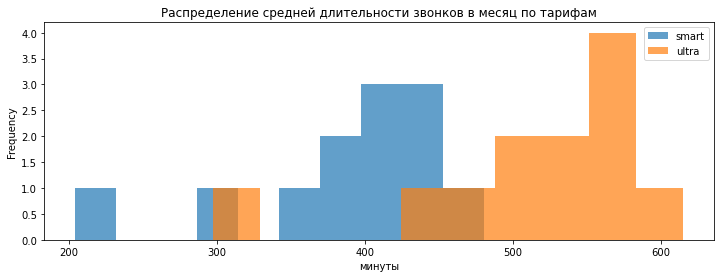

In [54]:
# создадим функцию отрисовки распределений по 2 разным таблицам и параметрам:

def distrib_by_tariffs(stat_smart, stat_ultra, column, xlabel, nbins, title):
    ax = stat_smart[column].plot(kind='hist', alpha=0.7, bins=nbins, label='smart', legend=True)

    stat_ultra[column].plot(kind='hist', alpha=0.7, bins=nbins, label='ultra', ax=ax, figsize=(12,4), legend=True)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

distrib_by_tariffs(calls_stat_smart, 
                   calls_stat_ultra, 
                   'mean',
                   'минуты',
                   nbins=10,
                   title='Распределение средней длительности звонков в месяц по тарифам'
)


Сделаем то же для сообщений и интернет-трафика:

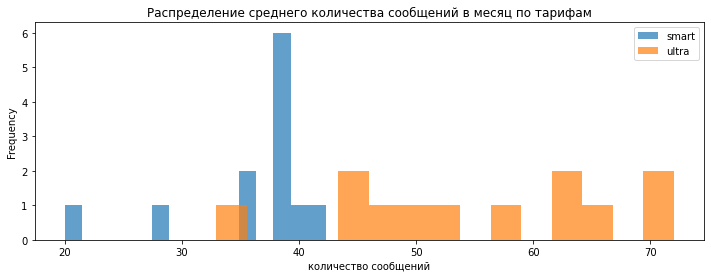

In [55]:
distrib_by_tariffs(messages_stat_smart, 
                   messages_stat_ultra, 
                   'mean',
                   'количество сообщений',
                   nbins=15,
                   title='Распределение среднего количества сообщений в месяц по тарифам'
)

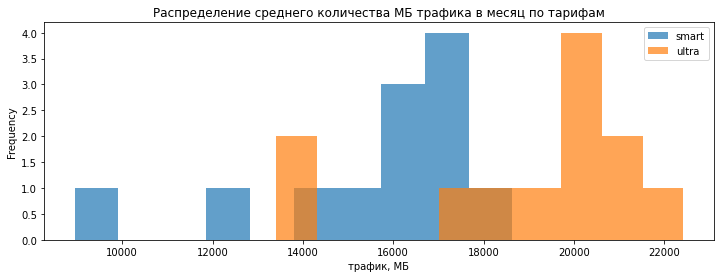

In [56]:
distrib_by_tariffs(internet_stat_smart, 
                   internet_stat_ultra, 
                   'mean',
                   'трафик, МБ',
                   nbins=10,
                   title='Распределение среднего количества МБ трафика в месяц по тарифам'
)

Посмотрим на стандартные отклонения средних этих же таблиц:

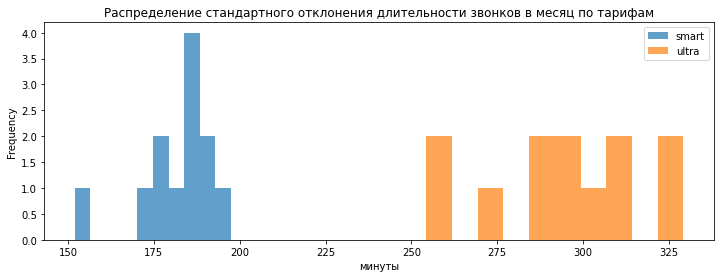

In [57]:
distrib_by_tariffs(calls_stat_smart, 
                   calls_stat_ultra, 
                   'std',
                   'минуты',
                   nbins=10,
                   title='Распределение стандартного отклонения длительности звонков в месяц по тарифам'
)

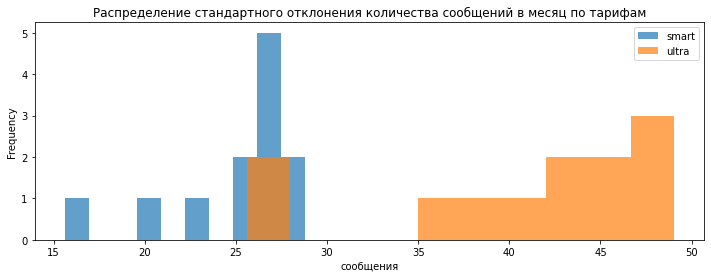

In [58]:
distrib_by_tariffs(messages_stat_smart, 
                   messages_stat_ultra, 
                   'std',
                   'сообщения',
                   nbins=10,
                   title='Распределение стандартного отклонения количества сообщений в месяц по тарифам'
)

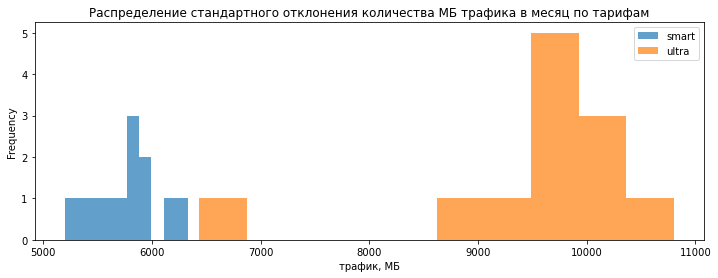

In [59]:
distrib_by_tariffs(internet_stat_smart, 
                   internet_stat_ultra, 
                   'std',
                   'трафик, МБ',
                   nbins=10,
                   title='Распределение стандартного отклонения количества МБ трафика в месяц по тарифам'
)

**Выводы:**

* вызовы
    * средняя длительность разговорв в месяц у пользователей тарифа `smart` около 390 минут, среднее стандартное отклонение 180 минут, больше 480 минут в среднем в месяц никто не разговаривает;
    * средняя длительность разговорв в месяц у пользователей тарифа `ultra` около 510 минут, среднее стандартное 
    отклонение 290 минут, больше 615 минут в среднем в месяц никто не разговаривает.

* сообщения
    * среднее количество сообщений у пользователей тарифа `smart` около 20 в месяц, среднее стандартное отклонение - 23 сообщения, больше 40 сообщений в среднем в месяц никто не отправляет;
    * среднее количество сообщений у пользователей тарифа `ultra` около 32 в месяц, среднее стандартное отклонение - 37 сообщения, больше 67 сообщений в среднем в месяц никто не отправляет.
    
* интернет-трафик
    * средний объем интернет-трафика у пользователей тарифа `smart` около 8 ГБ в месяц, среднее стандартное отклонение - 7 ГБ, больше 18 ГБ в среднем в месяц никто трафика потребляет (а больше 13 ГБ - в среднем менее 25%);
    * средний объем интернет-трафика у пользователей тарифа `ultra` около 11 ГБ в месяц, среднее стандартное отклонение - 10 ГБ, больше 21 ГБ в среднем в месяц никто трафика потребляет (а больше 17 ГБ - в среднем меньее 25%).

## Проверка гипотез<a name="hipotes"></a>

Проверим две гипотезы:

* средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Дадим описание первой гипотезы как обратное утверждение: определим гипотезу H₀ как среднее генеральной совокупности выручки по тарифу "Смарт" равно среднему генеральной совокупности выручки по тарифу "Ультра", тогда альтернативная гипотеза H₁ звучит как "среднее генеральной совокупности выручки по тарифу "Смарт" **не** равно среднему генеральной совокупности выручки по тарифу "Ультра".

In [60]:
# найдем среднюю месячную выручку по каждому тарифу
smart_income = total_income.query('tariff == "smart"')[[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
ultra_income  = total_income.query('tariff == "ultra"')[[1,2,3,4,5,6,7,8,9,10,11,12]].mean()

Выберем метод `ttest_ind()`, поскольку нам нужно сравнить между собой две генеральные совокупности по независимым выборкам: выборка ежемесячной выручки по тарифу "Смарт" и выборка ежемесячной выручки по тарифу "Ультра".

Уровень значимости `alpha` возьмем в 1%, поскольку выборка из 12 месяцев является небольшой, поэтому нам необходимо быть более уверенными в том, что наблюдаемое на выборке значение попадает зону (0%, 1%), вероятность такого события при верной нулевой гипотезе будет слишком малой, значит, у нас есть основание отвергнуть нулевую гипотезу.

In [61]:
# проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
# дисперсия выборок не равна между собой, потому что события являются независимыми
alpha = 0.01
results = st.ttest_ind(smart_income, ultra_income, equal_var = False)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


Отвергаем гипотезу H₀ - среднее генеральной совокупности выручки по тарифу "Смарт" **не** равно среднему генеральной совокупности выручки по тарифу "Ультра".

Поскольку обратное основной гипотезе утверждение оказалось неверным, значит, основную гипотезу мы не можем опровергнуть:

 **средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются,** поскольку обратное противоречит полученным данным.

Дадим описание второй гипотезы как обратное утверждение: определим гипотезу H₀ как среднее генеральной совокупности выручки пользователей из Москвы равно среднему генеральной совокупности выручки пользователей из других городов, тогда альтернативная гипотеза H₁ звучит как "среднее генеральной совокупности выручки пользователей из Москвы **не** равно среднему генеральной совокупности выручки пользователей из других городов".

Присоединим к таблице с выручкой `total_income` город каждого пользователя? затем создадим два массива со средней месячной выручкой по Москве - `moscow_income`, и остальными городами - `russia_income`:

In [62]:
# присоединяем к total_income города пользователей по user_id, 
# затем считаем среднемесячную выручку по Москве и другим городам
moscow_income = total_income.merge(users[['user_id', 'city']], on='user_id', how='left') \
                            .query('city == "Москва"')[[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
                            
russia_income  = total_income.merge(users[['user_id', 'city']], on='user_id', how='left') \
                             .query('city != "Москва"')[[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
# проверяем
moscow_income.head(2)

1    1020.707071
2    1020.222222
dtype: float64

Выберем метод `ttest_ind()`, поскольку нам нужно сравнить между собой две генеральные совокупности по независимым выборкам: выборка ежемесячной выручки пользователей из Москвы и выборка ежемесячной выручки пользователей из других городов. События независимы, поскольку платежи людей за связь в Москве не зависят от платежей людей за связь в других регионах.

Уровень значимости `alpha` возьмем в 1%, поскольку выборка из 12 месяцев является небольшой, поэтому нам необходимо быть более уверенными в том, что наблюдаемое на выборке значение попадает зону (0%, 1%), вероятность такого события при верной нулевой гипотезе будет слишком малой, значит, у нас есть основание отвергнуть нулевую гипотезу.

In [63]:
# проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
# дисперсия выборок не равна между собой, потому что события являются независимыми
alpha = 0.01
results = st.ttest_ind(moscow_income, russia_income, equal_var = False)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Не получилось отвергнуть нулевую гипотезу


Отвергнуть гипотезу H₀ на основании данных той выборки, что у нас есть, не удалось. Отбросить её мы не можем. Но у нас нет оснований утверждать, что гипотеза доказана:

возожно, средняя выручка пользователей из Москвы **не** отличается от выручки пользователей из других регионов.

Посмотрим, сколько пользователей в нашей выборки из Москвы:

In [64]:
users.query('city == "Москва"')['city'].count()

99

Поскольку всего 20% нашей выборки - это пользователи из Москвы, утверждать, что среднемесячная выручка по Москве не отличается от пользователей других регионов вместе взятых, нельзя - эту гипотезу всего лишь нельзя исключать, но это не значит, что она верна.

Посмотрим на распределение платежей по всем регионам, построив тепловую карту:

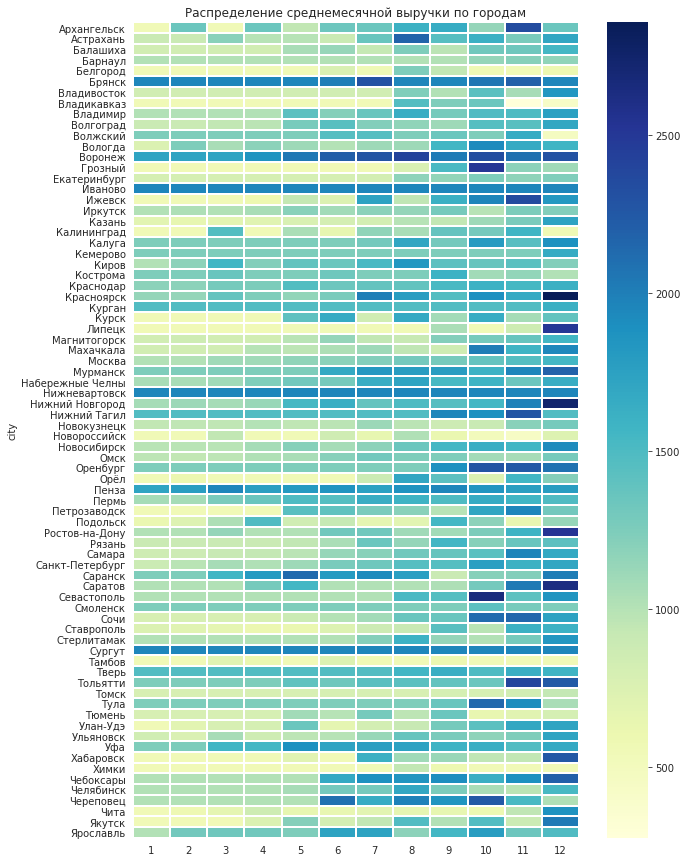

In [65]:
cities_income = total_income.merge(users[['user_id', 'city']], on='user_id', how='left') \
        .pivot_table(
            index = 'city',
            #columns=[1,2,3,4,5,6,7,8,9,10,11,12],
            values=[1,2,3,4,5,6,7,8,9,10,11,12],
            aggfunc='mean'
) 
with sps.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 15))
    ax = sps.heatmap(cities_income, cmap='YlGnBu', linewidths=1)
    plt.title('Распределение среднемесячной выручки по городам')

Выделяются города с большой среднемесячной выручкой: Брянск, Воронеж, Иваново, Нижневартовск, Пенза, Сургут.
Но пользователей в таких городах явно немного (меньше коэффициента Стьюдента в 30), чтобы делать выводы об общей выручки:

In [66]:
users.query('city in ["Брянск", "Воронеж", "Иваново", "Нижневартовск", "Пенза", "Сургут"]') \
    .groupby(by='city')['city'] \
    .count()

city
Брянск           3
Воронеж          6
Иваново          1
Нижневартовск    1
Пенза            6
Сургут           2
Name: city, dtype: int64

Таким образом, для отвержения второй гипотезы необходимо больше данных о пользователях.

Для финальной рекомендации компании "Мегалайн" подсчитаем общую выручку по каждому тарифу:

In [67]:
income_by_tariff = total_income.pivot_table(
    index='tariff',
    values=[1,2,3,4,5,6,7,8,9,10,11,12],
    aggfunc='sum'
)
income_by_tariff

,1,2,3,4,5,6,7,8,9,10,11,12
tariff,,,,,,,,,,,,
smart,198875,209151,240376,239316,284349,300309,328514,373590,373936,429317,437053,527565
ultra,290550,291150,292950,293400,297900,298050,305850,302850,293250,291150,292050,287550


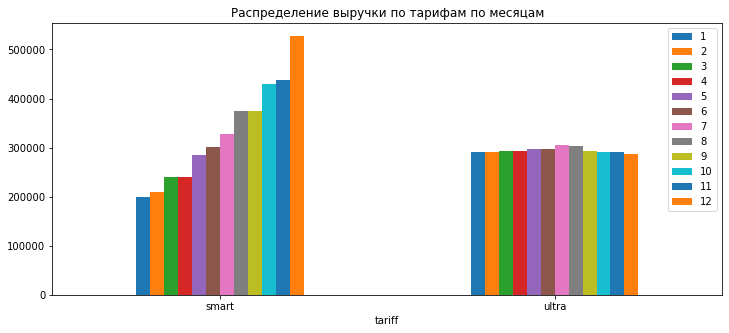

In [68]:
income_by_tariff.plot(
    kind='bar', 
    figsize=(12,5), 
    rot=0,
    title='Распределение выручки по тарифам по месяцам'
)
None

In [69]:
#Выведем итоговую сумму по каждому тарифу
income_by_tariff['Sum'] = income_by_tariff.sum(axis='columns')
income_by_tariff['Sum']

tariff
smart    3942351
ultra    3536700
Name: Sum, dtype: int64

## Выводы<a name="resume"></a>

В нашем распоряжении 5 таблиц: информация о пользователях (`users`), их звонках (`calls`), сообщениях (`messages`), интернет-сессиях (`internet`) и тарифах (`tariffs`).

Мы изучили пропуски, аномалии, привели необходимые данных к нужным типам.

Затем мы подсчитали выручку по каждому виду услуги для каждого пользователя в месяц (округлили время разговоров до минут вверх, а потраченные мегабайты - до гигабайт в месяц в бо́льшую сторону). При подсчете мы учли несколько пользователей, которые отказались от использования тарифа в течение 2018 года и вычли из общей выручки те ежемесячные суммы, которые клиенты точно не могли платить.

Поскольку в условии задачи не указано, в какой день денежные средства списываются со счета пользователя и возвращается ли ему часть средств абонентской платы, мы взяли немного **пессимистичный** сценарий, при котором клиенту возвращаеся вся сумма абонентской платы, если он не израсходовал лимит абонентской платы по своему тарифу в месяц отказа.

Для каждого пользователя:
* мы подсчитали для каждого пользователя количество сделанных звонков и израсходованных минут - `calls_pivot`;
* количество отправленных сообщений по месяцам - `messages_pivot`;
* объем израсходованного интернет-трафика по месяцам - `internet_pivot`;
* помесячную выручку с каждого пользователя - `total_income`.

Построили гистограммы распределения среднемесячной длительности разговоров, количества сообщений и объема интернет-трафика, построили также "ящик с усами" по этим значениям. <br>

Сделали следующие выводы:
* вызовы
    * средняя длительность разговорв в месяц у пользователей тарифа `smart` около 390 минут, среднее стандартное отклонение 180 минут, больше 480 минут в среднем в месяц никто не разговаривает;
    * средняя длительность разговорв в месяц у пользователей тарифа `ultra` около 510 минут, среднее стандартное 
    отклонение 290 минут, больше 615 минут в среднем в месяц никто не разговаривает.

* сообщения
    * среднее количество сообщений у пользователей тарифа `smart` около 20 в месяц, среднее стандартное отклонение - 23 сообщения, больше 40 сообщений в среднем в месяц никто не отправляет;
    * среднее количество сообщений у пользователей тарифа `ultra` около 32 в месяц, среднее стандартное отклонение - 37 сообщения, больше 67 сообщений в среднем в месяц никто не отправляет.
    
* интернет-трафик
    * средний объем интернет-трафика у пользователей тарифа `smart` около 8 ГБ в месяц, среднее стандартное отклонение - 7 ГБ, больше 18 ГБ в среднем в месяц никто трафика потребляет (а больше 13 ГБ - в среднем менее 25%);
    * средний объем интернет-трафика у пользователей тарифа `ultra` около 11 ГБ в месяц, среднее стандартное отклонение - 10 ГБ, больше 21 ГБ в среднем в месяц никто трафика потребляет (а больше 17 ГБ - в среднем меньее 25%).

Проверили две гипотезы и сделали следующие выводы:

* **средняя выручка пользователей тарифов "Ультра" и "Смарт" различаются,** поскольку обратное противоречит полученным в ходе анализа данным.
* возожно, средняя выручка пользователей из Москвы **не** отличается от выручки пользователей из других регионов вместе взятых. Это может быть связано как с количеством пользователей из Москвы (в выборке их всего 99 против 401 из других городов), а также разнородностью потребления услуг в разных регионах. Для более точного приближения к достоверности гипотезы необходимо провести анализ на большем количестве пользователей.

**Финальная рекомендация компании Мегалайн:**

По результатам проведенной работы по предоставленной выборке при планировании рекламного бюджета можно дать 2 рекомендации:
1. Тариф "Смарт" приносит больше выручки, чем "Ультра", при этом пользователи "Ультры" в среднем обходятся лимитами "Смарта". Соответственно, для увеличения выручки можно больше сконцентрировать внимание на рекламе тарифа "Смарт": таких пользователей в течение года становится больше и они начинают обгонять по выручке "Смарт". *(Самые доступные для людей тарифы часто - самые прибыльные)*
2. По региональному охвату можно распределить рекламный бюджет на регионы, приведя его к пропорции "Москва-регионы" - "20/80" *(мы не знаем как сейчас распределен бюджет)*, поскольку в среднем ежемесячная выручка пользователей из Москвы скорее всего не отличается от среднемесячной выручки пользователей из других городов, а по количеству - пользователей из Москвы 20% от общего числа клиентов Мегалайна.